## Importing libraries

In [1]:
# Input and Output from Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Stage 1 - ANN

## Get the data

In [2]:
# Generate input - output data

def generate_xt(num_samples=10):
    x = np.random.uniform(-1, 1, num_samples) # Input random
    # x = np.random.randint(-100, 100, num_samples) # Input random
    t = np.zeros(num_samples)
    
    t[0] = 0   # Inisialisasi
    
    for k in range(1, num_samples):
        t[k] = 1 / (1 + t[k-1]**2) + 0.25*x[k] - 0.3*x[k-1]
    
    df = pd.DataFrame({"x": x, "t": t})
    return df

df = generate_xt(30002)
print(df)

              x         t
0      0.099749  0.000000
1     -0.547299  0.833251
2      0.110644  0.782063
3     -0.869728  0.369868
4      0.825711  1.347007
...         ...       ...
29997  0.412249  1.119141
29998  0.009386  0.322628
29999  0.365519  0.994288
30000  0.591245  0.541020
30001  0.153988  0.634696

[30002 rows x 2 columns]


In [3]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t-1)" : df["t"].shift(1),
    "t(t-2)" : df["t"].shift(2),
    "t(t)"   : df["t"]   # target
})  # 3 lagged inputs and 2 lagged outputs

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)    t(t-1)    t(t-2)      t(t)
0  0.249675  0.935727  0.778226  1.000464  0.000000  0.281469
1  0.900867  0.249675  0.935727  0.281469  1.000464  1.076905
2 -0.327615  0.900867  0.249675  1.076905  0.281469  0.110858
3 -0.303403 -0.327615  0.900867  0.110858  1.076905  1.010293
4 -0.785843 -0.303403 -0.327615  1.010293  0.110858  0.389440
(30000, 6)


In [4]:
# dataset
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)", "t(t-1)", "t(t-2)"]].values   # input size=6
T = df_lagged[["t(t)"]].values    # target

# check size of dataset
print(X.shape, T.shape)

(30000, 5) (30000, 1)


## Splitting the dataset

In [5]:
def split_dataset_seq(X, T):
    """
    Membagi dataset 30.000 sample secara berurutan:
    - Train: 15.000 pertama
    - Val: 5.000 terakhir dari train + 5.000 setelah train
    - Test: 10.000 terakhir
    """
    assert len(X) == len(T), "Jumlah X dan T harus sama"
    assert len(X) == 30000, "Dataset harus 30.000 sample sesuai aturan"

    # Train 15.000 pertama
    X_train = X[:15000]
    T_train = T[:15000]

    # Validation = 5000 terakhir train + 5000 setelah train
    X_val = np.concatenate([X[10000:15000], X[15000:20000]])
    T_val = np.concatenate([T[10000:15000], T[15000:20000]])

    # Test = 10000 terakhir
    X_test = X[20000:30000]
    T_test = T[20000:30000]

    return X_train, T_train, X_val, T_val, X_test, T_test

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)


Train: (15000, 5) (15000, 1)
Val  : (10000, 5) (10000, 1)
Test : (10000, 5) (10000, 1)


## Neural Network Model

In [12]:
class NN:
    def __init__(self, input_size, hidden_size, output_size, lr=0.001, seed=42):
        np.random.seed(seed)

        # Parameters
        self.NI = input_size
        self.NH = hidden_size
        self.NO = output_size
        self.lr = lr

        # Weights
        self.v = np.random.rand(self.NI, self.NH)   # input x hidden
        self.vb = np.random.rand(self.NH)           # 1 x hidden
        self.w = np.random.rand(self.NH, self.NO)   # hidden x output
        self.wb = np.random.rand(self.NO)           # 1 x output

    # --- Set Weights ---
    def set_weights(self, weights):
        """Load weights from dict into the model"""
        self.v = weights["v"].copy()
        self.vb = weights["vb"].copy()
        self.w = weights["w"].copy()
        self.wb = weights["wb"].copy()

    # --- Get Weights ---
    def get_weights(self):
        """Return current weights as a dict"""
        return {
            "v": self.v.copy(),
            "vb": self.vb.copy(),
            "w": self.w.copy(),
            "wb": self.wb.copy()
        }
    
    # --- Activation functions ---
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    # Tanh Activation Function
    def tanh(self, x):
        return np.tanh(x)

    # Derivative of Tanh
    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    # --- Feedforward ---
    def feedforward(self, x):
        # hidden units
        self.z_in = np.dot(x, self.v) + self.vb
        self.z = self.sigmoid(self.z_in)                # change activation function here

        # output units
        self.y_in = np.dot(self.z, self.w) + self.wb
        #self.y = self.sigmoid(self.y_in)                # change activation function here! self.y is object in this class
        self.y = self.y_in                                                   

        return self.y

    # --- Backpropagation ---
    def backpropagation(self, x, t):
        # error output
        # delta_y = (t - self.y)*self.sigmoid_derivative(self.y_in)  # change activation function here
        delta_y = (t - self.y)                                   
        # del_w = self.lr * np.outer(self.z, delta_y)
        del_w = np.zeros_like(self.w)
        for k in range(self.NH):
            for j in range(self.NO):
                del_w[k][j] = self.lr * delta_y[j] * self.z[k]
        del_wb = self.lr * delta_y

        # error hidden
        delta_zin = np.dot(delta_y, self.w.T)
        delta_z = delta_zin * self.sigmoid_derivative(self.z_in)  # change activation function here
        # del_v = self.lr * np.outer(x, delta_z)
        del_v = np.zeros_like(self.v)
        for i in range(self.NI):
            for j in range(self.NH):
                del_v[i][j] = self.lr * delta_z[j] * x[i]
        del_vb = self.lr * delta_z

        # update bobot
        self.w += del_w
        self.wb += del_wb
        self.v += del_v
        self.vb += del_vb

        return np.mean(delta_y**2)   # return MSE

    # --- Training loop with validation for BPNN---
    def fit_bpnn(self, X_train, T_train, X_val=None, T_val=None,
            epochs=1000, tol=0.001, patience=20):
        history = {"train_loss": [], "val_loss": []}
        best_val_loss = float("inf")
        best_weights = None
        patience_ctr = 0             

        for epoch in range(epochs):
            mse = 0
            # training
            for i in range(len(X_train)):
                x = X_train[i]
                t = T_train[i]
                self.feedforward(x)
                mse += self.backpropagation(x, t)
            mse /= len(X_train)
            history["train_loss"].append(mse)       # mse for every epoch

            # validation
            if X_val is not None and T_val is not None:
                val_loss = 0
                for i in range(len(X_val)):
                    x = X_val[i]
                    t = T_val[i]
                    y = self.feedforward(x)
                    val_loss += np.mean((t - y)**2)
                val_loss /= len(X_val)
                history["val_loss"].append(val_loss)

                # early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = (self.v.copy(), self.vb.copy(), self.w.copy(), self.wb.copy())
                    patience_ctr = 0  # reset patience counter
                else:
                    patience_ctr += 1
                
                # stop training if no improvement for 'patience' epochs
                if patience_ctr >= patience:
                    print(f"Early stopping at epoch {epoch+1}, val_loss={val_loss:.6f}, train_loss={mse:.6f}")
                    if best_weights is not None:
                        self.v, self.vb, self.w, self.wb = best_weights
                    break

            # tolerance check (on training loss)
            if mse < tol:
                print(f"Training stopped at epoch {epoch+1}, train_loss={mse:.6f}")
                if best_weights is not None:
                    self.v, self.vb, self.w, self.wb = best_weights
                break

            if (epoch+1) % 10 == 0 or epoch == 0:
                if val_loss is not None:
                    print(f"Epoch {epoch+1}: train_loss={mse:.6f}, val_loss={val_loss:.6f}")
                else:
                    print(f"Epoch {epoch+1}: train_loss={mse:.6f}")

        return history
    
    # --- Training loop with validation for NARX---
    def fit_narx(self, X_train, T_train, X_val=None, T_val=None,
            epochs=1000, tol=0.001, patience=20, y_lags=2):
        history = {"train_loss": [], "val_loss": []}
        best_val_loss = float("inf")
        best_weights = None
        patience_ctr = 0             # ini untuk apa??

        for epoch in range(epochs):
            mse = 0
            # buffer awal for y-lag
            y_buffer = [np.zeros(self.NO) for _ in range(y_lags)]
            # training
            for i in range(len(X_train)):
                x_only = X_train[i]
                x = np.concatenate([x_only] + y_buffer)  # [x(t), y(t-1), y(t-2)]
                t = T_train[i]
                self.feedforward(x)
                mse += self.backpropagation(x, t)
                # update buffer
                y_buffer = [self.y] + y_buffer[:-1]
            mse /= len(X_train)
            history["train_loss"].append(mse)       # mse for every epoch

            # validation (no weight update)
            if X_val is not None and T_val is not None:
                val_loss = 0
                y_buffer_val = [np.zeros(self.NO) for _ in range(y_lags)]
                for i in range(len(X_val)):
                    x_only = X_val[i]
                    x = np.concatenate([x_only] + y_buffer_val)
                    t = T_val[i]
                    y = self.feedforward(x)
                    val_loss += np.mean((t - y)**2)
                    y_buffer_val = [y] + y_buffer_val[:-1]
                val_loss /= len(X_val)
                history["val_loss"].append(val_loss)

                # early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = (self.v.copy(), self.vb.copy(), self.w.copy(), self.wb.copy())
                    patience_ctr = 0  # reset patience counter
                else:
                    patience_ctr += 1
                
                # stop training if no improvement for 'patience' epochs
                if patience_ctr >= patience:
                    print(f"Early stopping at epoch {epoch+1}, val_loss={val_loss:.6f}, train_loss={mse:.6f}")
                    if best_weights is not None:
                        self.v, self.vb, self.w, self.wb = best_weights
                    break

            # tolerance check (on training loss)
            if mse < tol:
                print(f"Training stopped at epoch {epoch+1}, train_loss={mse:.6f}")
                if best_weights is not None:
                    self.v, self.vb, self.w, self.wb = best_weights
                break

            if (epoch+1) % 10 == 0 or epoch == 0:
                if val_loss is not None:
                    print(f"Epoch {epoch+1}: train_loss={mse:.6f}, val_loss={val_loss:.6f}")
                else:
                    print(f"Epoch {epoch+1}: train_loss={mse:.6f}")

        return history
    
    # --- Prediction ---
    def predict(self, X_test):
        outputs = []
        for x in X_test:
            outputs.append(self.feedforward(x))
        return np.array(outputs)
    
    # --- Prediction for NARX---
    def predict_narx(self, X_test, y_lags=2):
        outputs = []
        y_buffer = [np.zeros(self.NO) for _ in range(y_lags)]
        for x_only in X_test:
            x = np.concatenate([x_only] + y_buffer)
            y = self.feedforward(x)
            outputs.append(y)
            y_buffer = [y] + y_buffer[:-1]
        return np.array(outputs)


## Training and Validation

In [13]:
# create model
model = NN(input_size=X_train.shape[1], hidden_size=128, output_size=1, lr=0.001)

# training
history = model.fit_bpnn(X_train, T_train, X_val, T_val, epochs=1000, tol=1e-3, patience=20)

print("Last train loss:", history["train_loss"][-1])
print("Last val loss  :", history["val_loss"][-1])

# saving weights from previous training
weights = model.get_weights()

Epoch 1: train_loss=1.022778, val_loss=0.004466
Epoch 10: train_loss=0.002015, val_loss=0.001856
Epoch 20: train_loss=0.001322, val_loss=0.001230
Training stopped at epoch 30, train_loss=0.000987
Last train loss: 0.0009872148810700628
Last val loss  : 0.0009320943352503054


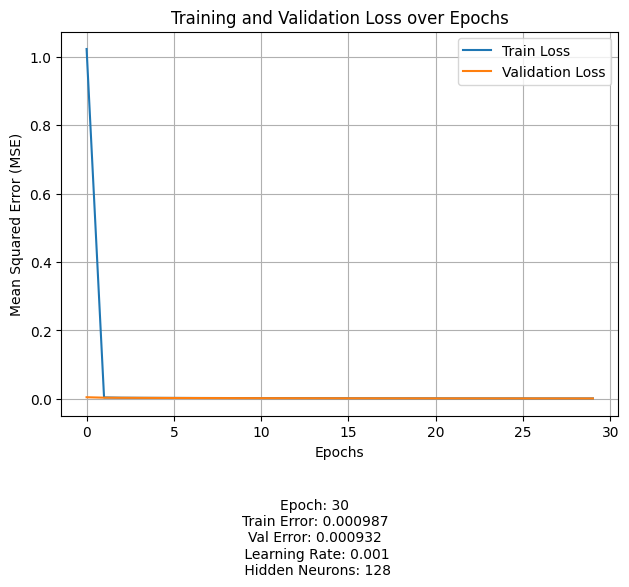

In [14]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}\n Learning Rate: {model.lr}\n Hidden Neurons: {model.NH}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

# Stage 2

## Getting the Data

In [15]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t)"   : df["t"]   # target
})  # 3 lagged inputs and 2 lagged outputs

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)      t(t)
0  0.249675  0.935727  0.778226  0.281469
1  0.900867  0.249675  0.935727  1.076905
2 -0.327615  0.900867  0.249675  0.110858
3 -0.303403 -0.327615  0.900867  1.010293
4 -0.785843 -0.303403 -0.327615  0.389440
(30000, 4)


## Splitting the dataset

In [16]:
# dataset
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)"]].values   # 100 sampel, input size=6
T = df_lagged[["t(t)"]].values    # target

# check size of dataset
print(X.shape, T.shape)

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)

(30000, 3) (30000, 1)
Train: (15000, 3) (15000, 1)
Val  : (10000, 3) (10000, 1)
Test : (10000, 3) (10000, 1)


## Training and validation

In [17]:
# buat model
y_lags = 2          # lags for feedback
model = NN(input_size=X_train.shape[1]+y_lags, hidden_size=128, output_size=1, lr=0.001)
model.set_weights(weights)

# training
history = model.fit_narx(X_train, T_train, X_val, T_val, epochs=1000, tol=1e-3, patience=20, y_lags=y_lags)

print("Last train loss:", history["train_loss"][-1])
print("Last val loss  :", history["val_loss"][-1])

Epoch 1: train_loss=0.001218, val_loss=0.001133
Epoch 10: train_loss=0.001012, val_loss=0.000957
Training stopped at epoch 11, train_loss=0.000996
Last train loss: 0.0009958729810262007
Last val loss  : 0.0009433357364825234


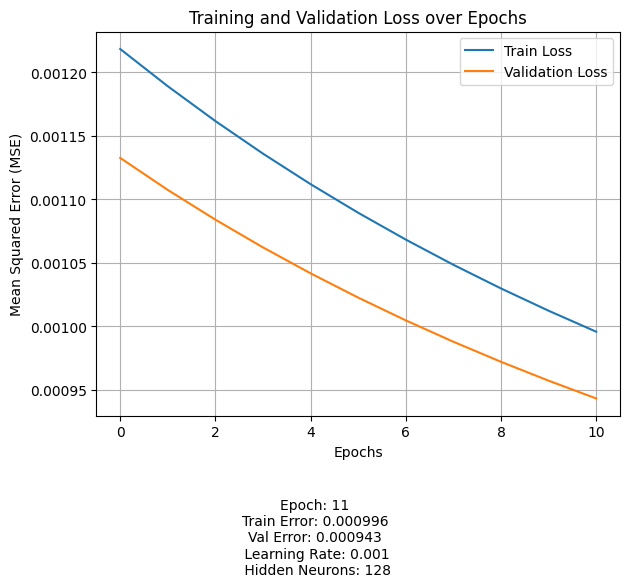

In [18]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}\n Learning Rate: {model.lr}\n Hidden Neurons: {model.NH}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [19]:
# testing
predictions = model.predict_narx(X_test, y_lags = y_lags)
mse_test = np.mean((T_test - predictions)**2)

print("Predictions:", predictions.flatten())
print("Test MSE:", mse_test)

Predictions: [ 1.0968987  -0.13911897  1.39867395 ...  0.88895143  0.84254777
  0.66964565]
Test MSE: 0.0009595635477675739


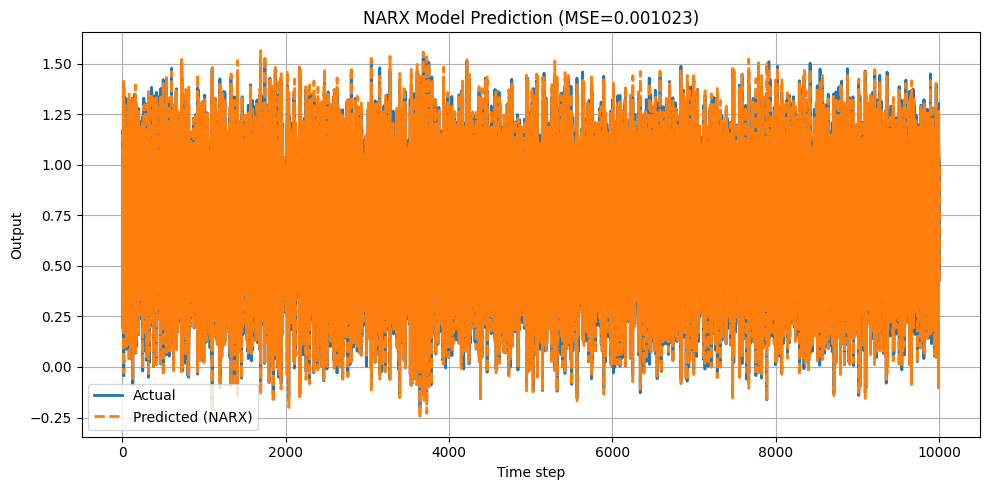

In [23]:
# --- prediction vs target plot ---
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(predictions, label='Predicted (NARX)', linestyle='--', linewidth=2)
plt.title(f'NARX Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
print(model.get_weights())

{'v': array([[ 3.80729012e-01,  9.46681800e-01,  7.11031743e-01,
         6.47182502e-01,  1.28265958e-01,  1.59395172e-01,
         1.10723669e-01,  8.68644669e-01,  6.16399434e-01,
         7.20543481e-01,  1.65835164e-02,  9.73305807e-01,
         8.51026639e-01,  2.16973773e-01,  1.60980382e-01,
         1.75096861e-01,  2.96140665e-01,  4.86766079e-01,
         4.35822671e-01,  2.83788017e-01,  6.03722638e-01,
         1.53584968e-01,  2.64028952e-01,  3.39810960e-01,
         4.55573926e-01,  8.09202493e-01,  9.64899507e-02,
         5.79857011e-01,  6.22386371e-01,  5.42494164e-02,
         6.27791434e-01,  1.99149597e-01,  9.35455250e-02,
         9.47174783e-01,  9.84597427e-01,  8.18996605e-01,
         3.05695502e-01,  1.34871282e-01,  6.86099101e-01,
         4.19857765e-01,  1.13216557e-01,  4.43671641e-01,
         6.86427960e-02,  9.27398360e-01,  1.80799951e-01,
         6.77760715e-01,  3.20323694e-01,  5.21757244e-01,
         5.48220850e-01,  1.86346150e-01,  9.34695